# Forecasting player performance in the National Hockey League

I propose to build a model to predict future player performance in the NHL. My data set, available at https://www.kaggle.com/martinellis/nhl-game-data/, contains every tracked event (shots, hits, takeaways, and more) with time and position, for NHL games since the start of the 2012 season. I will focus on goal scoring by forwards. I will try to explain the season-to-season change in goals scored for these players using the high-resolution event data as well as season-to-season data such as player age or time on ice. From the event data, I will build a support vector classifier model for expected goals---based on their position and other factors---to predict how many of the shots a player took should be expected to be goals. From this expected goals metric, I will quantify how 'unlucky' a player has been during a season. Along with other factors such as age, and time on ice, this luck parameter will be used in another model to forecast season-to-season change in goals scored. 


In [2]:
import numpy as np
import pandas as pd
import sys 
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from patsy import dmatrices
import datetime as dtm

In [5]:
filenames = ['game_plays', 'game_plays_players', 'game',
            'game_teams_stats', 'game_shifts' ,'game_skater_stats'
            ,'game_goalie_stats' ,'team_info' ,'player_info']
data_dir = '~/Documents/Employment/Data_incubator/2019_application/Project/data/nhl-game-data/'
dataframes = load_data(data_dir, filenames)

In [7]:
#data preprocessing load event data, player 
plays = dataframes['game_plays']
plays_players = dataframes['game_plays_players']
player_info  = dataframes['player_info']
games = dataframes['game']
shifts = dataframes['game_shifts']

In [17]:
plays.keys()

Index(['play_id', 'game_id', 'play_num', 'team_id_for', 'team_id_against',
       'event', 'secondaryType', 'x', 'y', 'period', 'periodType',
       'periodTime', 'periodTimeRemaining', 'dateTime', 'goals_away',
       'goals_home', 'description', 'st_x', 'st_y', 'rink_side'],
      dtype='object')

In [16]:
plays['event'].unique()

array(['Stoppage', 'Game Scheduled', 'Period Ready', 'Period Start',
       'Faceoff', 'Hit', 'Blocked Shot', 'Takeaway', 'Shot', 'Giveaway',
       'Missed Shot', 'Period End', 'Period Official', 'Penalty', 'Goal',
       'Game End', 'Game Official', 'Official Challenge',
       'Shootout Complete', 'Early Intermission Start',
       'Early Intermission End', 'Emergency Goaltender'], dtype=object)

In [8]:
#make season player stats
plays = plays.dropna(subset = ['st_x','st_y'])
plays = pd.merge(plays, plays_players[['play_id','player_id','playerType']],on='play_id')


In [31]:
plays.keys()

Index(['play_id', 'game_id', 'play_num', 'team_id_for', 'team_id_against',
       'event', 'secondaryType', 'x', 'y', 'period', 'periodType',
       'periodTime', 'periodTimeRemaining', 'dateTime', 'goals_away',
       'goals_home', 'description', 'st_x', 'st_y', 'rink_side', 'player_id',
       'playerType', 'primaryPosition'],
      dtype='object')

In [30]:
plays = pd.merge(plays,player_info[['player_id','primaryPosition']],on='player_id')

In [ ]:
plays = plays[plays['primaryPosition']!='D']

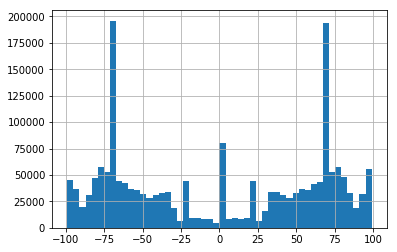

In [18]:
plays['x'].hist(bins=50)

In [10]:
#make season player stats
game_cut = dataframes['game'][['game_id', "date_time",'season', 'type']]#to calculate player age
game_cut = game_cut[game_cut['type']=='R'][['game_id','date_time','season']]#remove playoffs
player_info_cut = dataframes['player_info'][['player_id','birthDate','primaryPosition','firstName','lastName']]#to calculate player age
game_skater_stats = dataframes['game_skater_stats']#[['game_id','player_id','goals','assists','shots','timeOnIce','hits']]

#find ids of skaters that haven't taken enough shots, remove them
career_skater_shots = game_skater_stats.groupby(['player_id']).agg({'shots':'sum'}).reset_index()
career_skaters_truncated = career_skater_shots[career_skater_shots['shots']>200]['player_id']
season_skater_stats = pd.merge(game_skater_stats,career_skaters_truncated,on='player_id')

game_skater_stats = game_skater_stats.set_index('game_id').join(game_cut.set_index('game_id'))

game_skater_stats['season'] = game_skater_stats['season']%10000#get the year of the season
game_skater_stats = game_skater_stats.set_index('player_id').join(player_info_cut.set_index('player_id'))#

game_skater_stats['birthDate'] = pd.to_datetime(game_skater_stats['birthDate'],utc=True)
game_skater_stats['date_time'] = pd.to_datetime(game_skater_stats['date_time'],utc=True)
game_skater_stats['age'] = (game_skater_stats['date_time'] - game_skater_stats['birthDate']).dt.days/365 


agg_dict= {'goals':np.sum,'assists':np.sum,'shots':np.sum,'timeOnIce':np.sum,'hits':np.sum,'age':np.mean}
group_by_keys = ['player_id','season','primaryPosition']
season_skater_stats = game_skater_stats.groupby(group_by_keys).agg(agg_dict)
#season_skater_stats.reset_index()

season_skater_stats['TOI'] = season_skater_stats['timeOnIce'].apply(lambda x: x/3600)
season_skater_stats['max_TOI'] = season_skater_stats.groupby(['player_id'])['TOI'].apply(lambda x: x.max())
#season_skater_stats = season_skater_stats[season_skater_stats['max_TOI'] > 4 ]
#season_skater_stats.reset_index()



season_skater_stats['next_TOI'] = season_skater_stats.groupby(['player_id'])['TOI'].apply(lambda x: x-x.diff(periods=-1))
season_skater_stats['next_goals'] = season_skater_stats.groupby(['player_id'])['goals'].apply(lambda x: x-x.diff(periods=-1))
season_skater_stats['next_shots'] = season_skater_stats.groupby(['player_id'])['shots'].apply(lambda x: x-x.diff(periods=-1))
season_skater_stats['cTOI'] = season_skater_stats.groupby(['player_id'])['timeOnIce'].apply(lambda x: x.cumsum())
season_skater_stats['chits'] = season_skater_stats.groupby(['player_id'])['hits'].apply(lambda x: x.cumsum())
season_skater_stats['gps'] = season_skater_stats['goals']/season_skater_stats['shots']
season_skater_stats['gp60'] = season_skater_stats['goals']/season_skater_stats['TOI']
season_skater_stats['next_gp60'] = season_skater_stats['next_goals']/season_skater_stats['next_TOI']
season_skater_stats['sp60']= season_skater_stats['shots']/season_skater_stats['TOI']
season_skater_stats['next_sp60'] = season_skater_stats['next_shots']/season_skater_stats['next_TOI']

season_skater_stats = season_skater_stats.reset_index()
season_skater_stats = season_skater_stats.dropna(subset=['next_gp60'])#final seasons won't have this


#season_defence_stats = season_skater_stats[season_skater_stats['primaryPosition']=='D']
season_forward_stats = season_skater_stats[season_skater_stats['primaryPosition']!='D']



In [11]:
season_skater_stats.keys()

Index(['player_id', 'season', 'primaryPosition', 'goals', 'assists', 'shots',
       'timeOnIce', 'hits', 'age', 'TOI', 'max_TOI', 'next_TOI', 'next_goals',
       'next_shots', 'cTOI', 'chits', 'gps', 'gp60', 'next_gp60', 'sp60',
       'next_sp60'],
      dtype='object')

0.09574241585504585


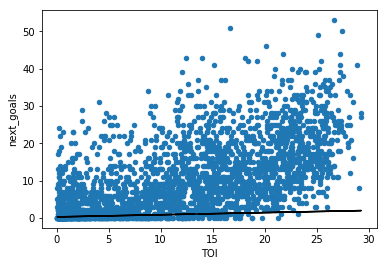

In [12]:
#season_forward_stats.plot('sp60','gp60',kind='scatter')
fig, ax = plt.subplots(1)
season_forward_stats.plot('TOI','next_goals',kind='scatter',ax=ax)
slope, intercept, r, p, stderr = stats.linregress(season_forward_stats['sp60'],season_forward_stats['next_gp60'])
sp60 = season_forward_stats['TOI'].values
ax.plot(sp60,slope*sp60+intercept,'k-')
print(r**2)
#season_forward_stats['TOI'].hist(bins=50)


0.4623632186919894


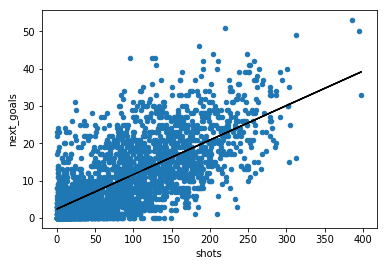

In [119]:
#season_forward_stats.plot('sp60','gp60',kind='scatter')
fig, ax = plt.subplots(1)
season_forward_stats.plot('shots','next_goals',kind='scatter',ax=ax)
slope, intercept, r, p, stderr = stats.linregress(season_forward_stats['shots'],season_forward_stats['next_goals'])
sp60 = season_forward_stats['shots'].values
ax.plot(sp60,slope*sp60+intercept,'k-')
print(r**2)
#season_forward_stats['TOI'].hist(bins=50)

# Naive expected goals

As a base model for comparsion, we can predict expected goals as the league-average shooting percentage multiplied by the number of shots a player has taken.  We find that this expected goals metric is able to explain 84% of the variance in actual goals scored by players per season. We also find a statistically significant positive correlation between season-to-season goals scored and the difference between expected and actual goals using this model, however we are only able to explain 5.1% of the variance in season-to-season scoring using this variable.

In [4]:
#select only Forwards 
game_plays = dataframes['game_plays']
game_plays_players = dataframes['game_plays_players']

Text(-18, 32, 'p = 1.32e-29')

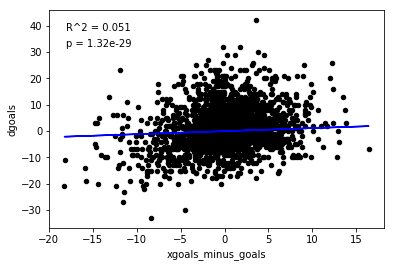

In [10]:
# naive xgoals = shots*league average shooting percentage
game_S_stats = dataframes['game_skater_stats']
player_info  = dataframes['player_info']
game = dataframes['game']
game_S_stats = pd.merge(game_S_stats, player_info, on='player_id')
game_S_stats = pd.merge(game_S_stats, game, on='game_id')
game_F_stats = game_S_stats[game_S_stats['primaryPosition']!='D']
season_agg = {'goals':'sum','shots':'sum','powerPlayGoals':'sum','timeOnIce':'sum'}
season_F_stats = game_F_stats.groupby(['player_id','season']).agg(season_agg)
season_F_stats = season_F_stats.reset_index()
gps, g0, r, p, stderr = stats.linregress(season_F_stats['shots'],season_F_stats['goals'])

#shooting percentage is goals/shots
season_F_stats['gps'] = season_F_stats['goals']/season_F_stats['shots']

#calculate naive xgoals
season_F_stats['xgoals'] = gps*season_F_stats['shots']+g0
season_F_stats['xgoals_minus_goals'] = season_F_stats['xgoals'] - season_F_stats['goals']
#be careful about taking the right difference! pandas convention different than numpy
season_F_stats['dgoals'] = season_F_stats.groupby(['player_id'])['goals'].apply(lambda x: -x.diff(periods=-1))
season_F_stats = season_F_stats.dropna(subset=['dgoals'])#final seasons won't have dgoals



#how well does xgoals predict/correlate to season-to-season change in goals
slope, intercept, r, p, stderr = stats.linregress(season_F_stats['dgoals'],season_F_stats['xgoals_minus_goals'])
fig2, ax2 = plt.subplots(1)
season_F_stats.plot('xgoals_minus_goals', 'dgoals',kind='scatter',color='k',ax=ax2)
xgmg = season_F_stats['xgoals_minus_goals'].values
ax2.plot(xgmg, slope*xgmg+intercept,'b-')
plt.text(-18,38,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
plt.text(-18,32,'p = {}'.format(round(p,-int(np.log10(p)-3))))


Text(0, 50, 'p = 0.0')

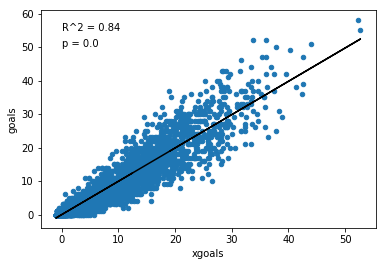

In [6]:
#how well does xgoals predict/correlate to goals?
slope, intercept, r, p, stderr = stats.linregress(season_F_stats['xgoals'],season_F_stats['goals'])
fig, ax = plt.subplots(1)
season_F_stats.plot('xgoals','goals',kind='scatter',ax=ax)
xgoals = season_F_stats['xgoals'].values
ax.plot(xgoals, slope*xgoals +intercept,'k')
plt.text(0,55,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
plt.text(0,50,'p = {}'.format(p))

# Expected goals from spatially resolved shooting percentage 

Using data about shot quality, we can improve our expected goals model. As a proof of principle, we construct a spatially-resolved league-average shooting percentage model using a SVC. We then predict expected goals using this model and the shot location data. We find that this improved expected goals metric is now able to explain 87% of the variance in actual goals scored by players per season. We also find an improved correlation between season-to-season goals scored and the difference between expected and actual goals using this model. This spatially-resolved expected goals model is able to explain 8.8% of the variance in season-to-season scoring.

First we isolate shot data from the event dataframe, and drop events for which position is not recorded. We split this cleaned dataframe to obtain a subset small enough to allow training of our shooting percentage model in a reasonable time.

In [7]:
#select data we want
game_plays = dataframes['game_plays']
game_plays_players = dataframes['game_plays_players']

#select shot events (from shooters, don't double count with goalie)
shot_events = ['Goal','Shot','Missed Shot']
game_plays = game_plays[game_plays['event'].isin(shot_events)]
game_plays = pd.merge(game_plays, game_plays_players[['play_id','player_id','playerType']],on='play_id')
game_plays = game_plays[game_plays['playerType'].isin(['Shooter','Scorer'])]

game_plays = pd.merge(game_plays,dataframes['game'][['game_id','season']],on='game_id')

#missed shots and saved shots  will be treated the same, neither went in
event_dict = {'Goal':1,'Shot':0,'Missed Shot':0}
game_plays['event'] = game_plays['event'].apply(lambda x: event_dict[x])

#drop data for which x, y coordinates are missing
game_plays = game_plays.dropna(subset = ['st_x','st_y'])

#prepare training datea
y, X = dmatrices('event ~ st_x + st_y-1', game_plays, return_type = 'dataframe')
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .8)


Next we define and train our SVC for a few hyperparameters. I have chosen a gaussian kernal with standard deviation between 5 or 10 feet. This is motivated by the sparsity of our goal data--we don't want to accidentally learn hotspots exactly where past goals have been scored from--as well as my experience playing hockey--I don't notice a difference of 1 foot while shooting on net, but 10 feet can make a difference. This step takes a LONG time, even for a small subset of the data.

In [8]:
#define and train the SVMs for a few hyperparameters
#this takes a long time and is quadratic in the size of the training set
start = time.time()
#sigma for the rbf kernels should be a few feet based on my hockey experience
gammas = {'10':1/(5**2), '5':1/(5**2), 'auto':'auto'}
clfs = {}
for key in gammas.keys():
    gamma = gammas[key]
    clfs[key] = SVC(gamma=gamma,probability=True,class_weight='balanced')
    clfs[key].fit(X_train, y_train)
fit_time = (time.time()-start)/60
print(fit_time) 

287.95517131884895


Our spatially-resolved shooting percentage naturally lends itself to visualisation. We plot the probability density for the class 'goals' as a function of position on the rink.

In [66]:
#prepare a meshgrid with the spatially-resolved shooting percentage prediction for plotting
numx = 201 #size of 1/2 of the rink in feet
numy = 171
(xmin,xmax) = (0,100)
yrad = 45.5
x,y = np.meshgrid(np.linspace(xmin,xmax,numx),np.linspace(-yrad,yrad,numy))
z = {}
start = time.time()
for key in gammas.keys():
    z[key] = np.reshape(clfs[key].predict_proba(np.array([x.ravel(),y.ravel()]).T)[:,1],(numy,numx))
total = time.time() - start
print(total)
print(dtm.datetime.now())
print('done')

153.14296793937683
2019-02-04 07:32:23.156746
done


We find that there is not a visually noticable difference between the shooting percentage for the 10 foot and 5 foot gaussian kernels. The model with an automatically determined kernal standard deviation picks out hot-spots where past goals were scored (not shown, would need to retrain the model and I don't have 6 hours). Further thought is required to optimize this hyperparameter choice.

0.009199857711791992
2019-02-04 05:48:30.047201
done


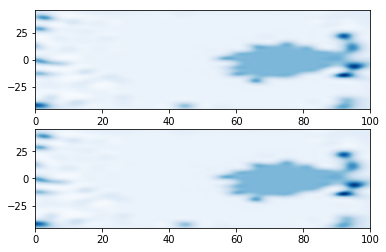

In [10]:
#plot the spatially-resolved shooting percentage for each hyperparameter
plotgammas = {'10':0,'5':0}
fig, ax = plt.subplots(len(plotgammas.keys()))
i = 0
start = time.time()
for key in plotgammas.keys():
    ax[i].pcolormesh(x,y,z[key],shading='gouraud',cmap='Blues')
    i += 1
total = time.time() - start
print(total)
print(dtm.datetime.now())
print('done')

The 10-foot gaussian kernal gave the expected goals metric which ended up being most predictive of season-to-season change in goals scored. We plot it below with annotation to orient the viewer with respect to features of a hockey rink.

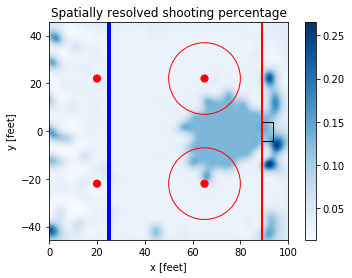

In [67]:
#plot the spatially-resolved shooting percentage for sigma=10, which gave the best R^2 to predict season-to-season change in goals
#annotate the plot properly so it's easy to interpret
fig, ax = plt.subplots(1)
cb = ax.pcolormesh(x,y,z['10'],shading='gouraud',cmap='Blues')#,norm=matplotlib.colors.LogNorm())
ax.set_xlabel('x [feet]')
ax.set_ylabel('y [feet]')
ax.set_aspect('equal')

#plot the rink
plt.axvline(x=25,color='b',linewidth=4)# blue line for offensive zone
plt.axvline(x=100-11,color='r',linewidth=2)# blue line for offensive zone
ax.add_patch(plt.Circle((65,22),15,color='r',fill=False))# faceoff circle
ax.add_patch(plt.Circle((65,-22),15,color='r',fill=False))# faceoff circle
ax.add_patch(plt.Circle((65,22),1.5,color='r',fill=True))# faceoff dot
ax.add_patch(plt.Circle((65,-22),1.5,color='r',fill=True))# faceoff dot
ax.add_patch(plt.Circle((20,22),1.5,color='r',fill=True))# faceoff dot
ax.add_patch(plt.Circle((20,-22),1.5,color='r',fill=True))# faceoff dot
goal_loc = matplotlib.patches.Rectangle((89,-4),4.5,8,color='k',fill=False)# the goal
ax.add_patch(goal_loc)#the goal
plt.colorbar(cb)#color bar so you can read the plot ~quantitatively
ax.set_title('Spatially resolved shooting percentage')
plt.savefig('TDI_FIG1.pdf')

Finally we need to use the shooting-percentage model to predict expected goals based on shot data. For each shot, we calculate a probability that it will be a goal, and save this to a new column in the event datafram. We then group by players and seasons to find aggregate season stats including expected goals.

In [12]:
#calculate expected goals from each shot based on shot position using the learned models
#this takes a lot of time because there's a lot of data
#should take care not to use the training data in testing..
coords = np.array([game_plays['st_x'].values, game_plays['st_y'].values])
gprobs = {}
start = time.time()
for key in gammas.keys():
    gprobs[key] = clfs[key].predict_proba(coords.T)
total = time.time() - start
print(total)
print(dtm.datetime.now())
print('done')

2694.413110733032
2019-02-04 06:33:26.259494
done


In [62]:
#Write expected goals to dataframe
game_plays['xgoals'] =  gprobs['10'].T[1]
game_plays.head()
season_player = game_plays.groupby(['player_id','season']).agg({'event':{'shots':'count','goals':'sum'},'xgoals':'sum'})
season_player.columns = ['shots', 'goals', 'xgoals']
season_player = season_player.reset_index()
season_player['dgoals'] = season_player.groupby(['player_id'])['goals'].apply(lambda x: -x.diff(periods=-1))
season_player['dshots'] = season_player.groupby(['player_id'])['shots'].apply(lambda x: -x.diff(periods=-1))

season_player = season_player.dropna(subset = ['dgoals'])
season_player['xgmg'] = season_player['xgoals']- season_player['goals']
season_player.plot('xgmg','dgoals',kind='scatter',ax=ax2)




(0.08789642807026754, 7.052794010099072e-75)


We find that this expected goals metric is able to explain 87% of the variance in actual goals scored by players per season. This means spatially-resolved shooting percentage is a better indicator of shot quality than league-average shooting percentage, but there are clearly more factors that determine shot quality. We again find a statistically significant positive correlation between season-to-season goals scored and the difference between expected and actual goals using this model, and we are now able to explain 8.8% of the variance in season-to-season scoring using this variable.

(0.08789642807026754, 7.052794010099072e-75)


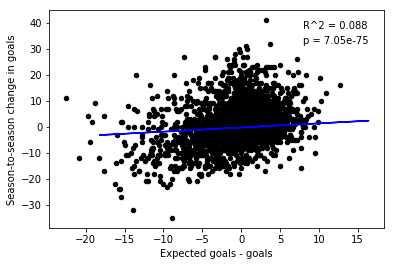

In [64]:
#regression of season-to-season goal change vs xgoals - goals
slope, intercept, r, p, stderr = stats.linregress(season_player['dgoals'].values, season_player['xgmg'].values)
print((r**2,p))
fig2, ax2 = plt.subplots(1)
ax2.plot(xgmg, slope*xgmg+intercept,'b-')
season_player.plot('xgmg','dgoals',kind='scatter',color='k',ax=ax2)
ax2.set_xlabel('Expected goals - goals')
ax2.set_ylabel('Season-to-season change in goals')
plt.text(8,38,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
plt.text(8,32,'p = {}'.format(round(p,-int(np.log10(p)-3))))
plt.savefig('TDI_FIG2.pdf')

Text(0, 50, 'p = 0.0')

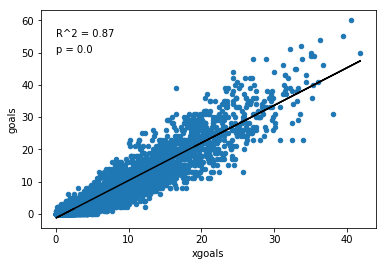

In [51]:
#how well does xgoals predict/correlate to goals?
slope, intercept, r, p, stderr = stats.linregress(season_player['xgoals'],season_player['goals'])
fig, ax = plt.subplots(1)
season_player.plot('xgoals','goals',kind='scatter',ax=ax)
xgoals = season_player['xgoals'].values
ax.plot(xgoals, slope*xgoals +intercept,'k')
plt.text(0,55,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
plt.text(0,50,'p = {}'.format(p))

# Other factors effecting season-to-season goal scoring

Changes in goals scored by season can clearly be caused by factors besides luck. Eventually we will be interested in separating the impact of a minimal important set of variables that determine fluctuations in goal scoring. An obvious example of a variable that could effect scoring is shots: if a player takes more shots, they are likely to score more goals. Using linear regression, we show below that season-to-season changes in shots taken may account for 54% of the variance in season-to-season goal scoring. This is one of many factors that must be accounted for in our model to forecast future goal scoring.

p = 0.0 to machine precision


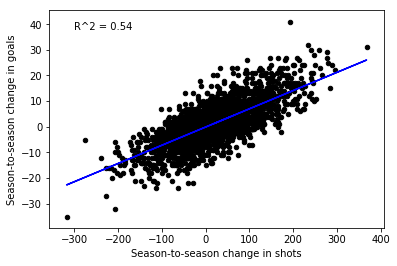

In [60]:
slope, intercept, r, p, stderr = stats.linregress(season_player['dshots'].values, season_player['dgoals'].values)
dshots = season_player['dshots'].values
fig2, ax2 = plt.subplots(1)
ax2.plot(dshots, slope*dshots+intercept,'b-')
season_player.plot('dshots','dgoals',kind='scatter',color='k',ax=ax2)
ax2.set_xlabel('Season-to-season change in shots')
ax2.set_ylabel('Season-to-season change in goals')
plt.text(-300,38,'R^2 = {}'.format(round(r**2,-int(np.log10(r**2)-2))))
print('p = {} to machine precision'.format(p))

# Appendix: rough exploratory analysis. Everything below here is poorly commented

In [16]:
#Exploratory analysis

game_cut = dataframes['game'][['game_id', "date_time",'season', 'type']]#to calculate player age
game_cut = game_cut[game_cut['type']=='R'][['game_id','date_time','season']]#remove playoffs
player_info_cut = dataframes['player_info'][['player_id','birthDate','primaryPosition','firstName','lastName']]#to calculate player age
game_skater_stats = dataframes['game_skater_stats']#[['game_id','player_id','goals','assists','shots','timeOnIce','hits']]
game_skater_stats = game_skater_stats.set_index('game_id').join(game_cut.set_index('game_id'))

game_skater_stats['season'] = game_skater_stats['season']%10000#get the year of the season
game_skater_stats = game_skater_stats.set_index('player_id').join(player_info_cut.set_index('player_id'))#

game_skater_stats['birthDate'] = pd.to_datetime(game_skater_stats['birthDate'],utc=True)
game_skater_stats['date_time'] = pd.to_datetime(game_skater_stats['date_time'],utc=True)
game_skater_stats['age'] = (game_skater_stats['date_time'] - game_skater_stats['birthDate']).dt.days/365 
agg_dict= {'goals':np.sum,'assists':np.sum,'shots':np.sum,'timeOnIce':np.sum,'hits':np.sum,'age':np.mean}
group_by_keys = ['player_id','firstName','lastName','season','primaryPosition']

season_skater_stats = game_skater_stats.groupby(group_by_keys).agg(agg_dict)
season_skater_stats.reset_index()
season_skater_stats['dgoals'] = season_skater_stats.groupby(['player_id'])['goals'].apply(lambda x: x.diff())
season_skater_stats['dshots'] = season_skater_stats.groupby(['player_id'])['shots'].apply(lambda x: x.diff())
season_skater_stats['cTOI'] = season_skater_stats.groupby(['player_id'])['timeOnIce'].apply(lambda x: x.cumsum())
season_skater_stats['chits'] = season_skater_stats.groupby(['player_id'])['hits'].apply(lambda x: x.cumsum())
season_skater_stats['gps'] = season_skater_stats['goals']/season_skater_stats['shots']
season_skater_stats = season_skater_stats.reset_index()

season_defence_stats = season_skater_stats[season_skater_stats['primaryPosition']=='D']
season_forward_stats = season_skater_stats[season_skater_stats['primaryPosition']!='D']


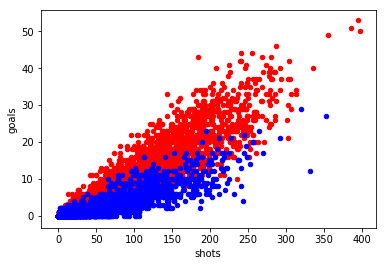

In [17]:
fig, ax = plt.subplots()
season_forward_stats.plot('shots','goals',kind='scatter',ax=ax,color='r')
season_defence_stats.plot('shots','goals',kind='scatter',ax=ax,color='b')

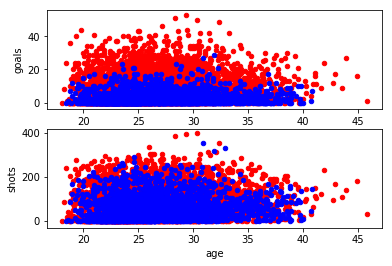

In [18]:
fig, ax = plt.subplots(2)
season_forward_stats.plot('age','goals',kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot('age','goals',kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot('age','shots',kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot('age','shots',kind='scatter',ax=ax[1],color='b')



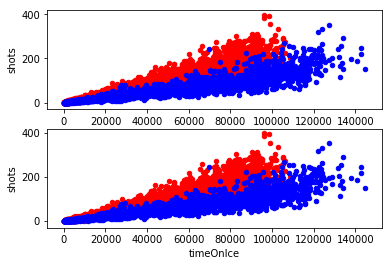

In [19]:
fig, ax = plt.subplots(2)
xkey = 'timeOnIce'
ykey1 = 'shots'
ykey2 = 'assists'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[1],color='b')

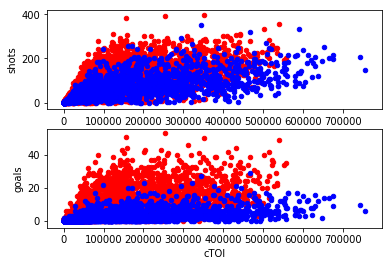

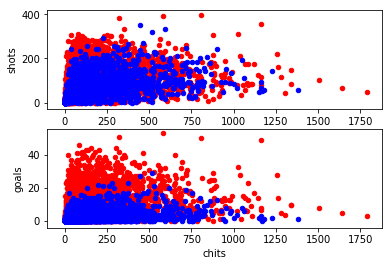

In [20]:
fig, ax = plt.subplots(2)
xkey = 'cTOI'
ykey1 = 'shots'
ykey2 = 'goals'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='b')
fig, ax = plt.subplots(2)
xkey = 'chits'
ykey1 = 'shots'
ykey2 = 'goals'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='b')

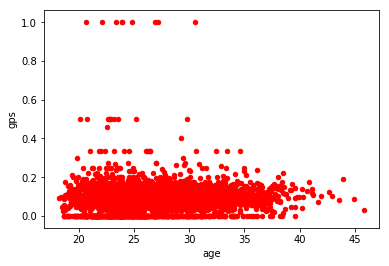

In [21]:
fig, ax = plt.subplots(1)
season_forward_stats.plot('age','gps',kind='scatter',ax=ax,color='r')

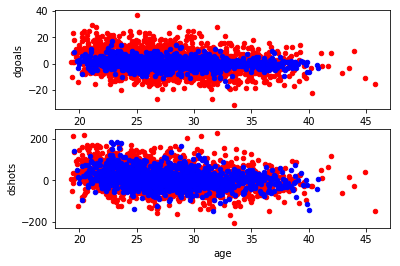

In [22]:
fig, ax = plt.subplots(2)
xkey = 'age'
ykey1 = 'dgoals'
ykey2 = 'dshots'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='b')

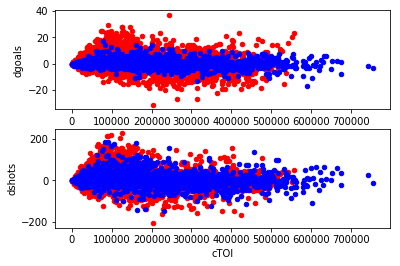

In [23]:
fig, ax = plt.subplots(2)
xkey = 'cTOI'
ykey1 = 'dgoals'
ykey2 = 'dshots'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax[0],color='b')
season_forward_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='r')
season_defence_stats.plot(xkey,ykey2,kind='scatter',ax=ax[1],color='b')

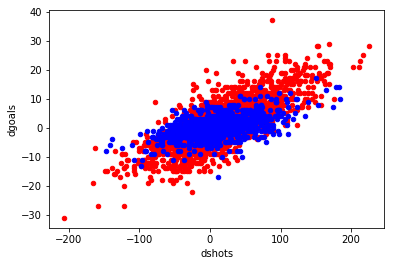

In [24]:
fig, ax = plt.subplots(1)
xkey = 'dshots'
ykey1 = 'dgoals'
ykey2 = 'dshots'
season_forward_stats.plot(xkey,ykey1,kind='scatter',ax=ax,color='r')
season_defence_stats.plot(xkey,ykey1,kind='scatter',ax=ax,color='b')

In [25]:
#feature expansion to shot angle and shot distance
goal_x, goal_y = 89, 0 #location of the goal
goal_y = 0
game_plays['shot_r'] = (((game_plays['st_x']-goal_x).apply(np.square)+(game_plays['st_y']-goal_y).apply(np.square)).apply(np.sqrt))
game_plays['shot_phi'] = ((goal_x-game_plays['st_x'] + 1j*game_plays['st_y']).apply(np.angle)).apply(np.abs)


# Definitions

In [4]:
#definition to load specified dataframes
def load_data(data_dir, filenames):
    dataframes = {}
    #filenames = ['game_skater_stats',]
    for filename in filenames:
        dataframes[filename] = pd.read_csv(data_dir+filename+'.csv')
        #print('{}.csv read to dataframes'.format(filename))
    return dataframes